#### iris 데이터셋 활용 꽃잎 너비 예측 모델
- 데이터셋 : iris.csv에서 2개 Feature 사용
- 구현프레임워크 : Pytorch

- [1] 모듈 로딩 및 데이터 준비

In [2]:
# 모듈 로딩
import torch                    # 텐서 및 수치 계산 함수 관련 모듈
import torch.nn as nn           # 인공신경망 관련 모듈
import torch.nn.functional as F    # 손실, 거리 등 함수 관련 모듈
import torch.optim as optimizer # 최적화 기법 관련 모듈
import pandas as pd             # 데이터 파일 분석 관련 모듈
from sklearn.model_selection import train_test_split        

In [3]:
torch.manual_seed(1)

In [4]:
# 데이터 로딩 : CSV => DataFrame
DATA_FILE='../data/iris.csv'

irisDF=pd.read_csv(DATA_FILE, usecols=[0,1,2,3])
irisDF.head()

,sepal.length,sepal.width,petal.length,petal.width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


[2] 모델 준비
- 학습방법 : 지도학습 > 회귀
- 알고리즘 : 선형관계 >> 선형모델 ==> nn.Linear

In [5]:
# in_features : sepal.length, sepal.width, petal.length 3개
# out_features : petal.width 1개
model=nn.Linear(3,10)

nnmodel=nn.Sequential(nn.Linear(3,10), nn.ReLU(), nn.Linear(10,50), nn.ReLU(), nn.Linear(50,1))

In [6]:
# 가중치와 절편 확인
for name, param in model.named_parameters():
    print(f'[{name}] {param}\n')

[weight] Parameter containing:
tensor([[ 0.2975, -0.2548, -0.1119],
        [ 0.2710, -0.5435,  0.3462],
        [-0.1188,  0.2937,  0.0803],
        [-0.0707,  0.1601,  0.0285],
        [ 0.2109, -0.2250, -0.0421],
        [-0.0520,  0.0837, -0.0023],
        [ 0.5047,  0.1797, -0.2150],
        [-0.3487, -0.0968, -0.2490],
        [-0.1850,  0.0276,  0.3442],
        [ 0.3138, -0.5644,  0.3579]], requires_grad=True)

[bias] Parameter containing:
tensor([ 0.1613,  0.5476,  0.3811, -0.5260, -0.5489, -0.2785,  0.5070, -0.0962,
         0.2471, -0.2683], requires_grad=True)



[3] 최적화 인스턴스 준비

In [7]:
### 모델의 가중치와 절편을 최적화 ==> 인스턴스에 전달
adam_optim=optimizer.Adam(model.parameters(),lr=0.1)

[4] 학습 ==> 개발자가 구현

- [4-1] 데이터셋 Tensor화 진행 : 데이터 준비 시 진행하거나 또는 학습 전 진행

In [8]:
featureTS=torch.from_numpy(irisDF[irisDF.columns[:-1]].values).float()
featureTS.shape

torch.Size([150, 3])

In [9]:
targetTS=torch.from_numpy(irisDF[['petal.width']].values).float()
targetTS.shape

torch.Size([150, 1])

In [10]:
# Train & Test
X_train, X_test, y_train, y_test=train_test_split(featureTS,targetTS,test_size=0.2)

# Train & Valid
X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, test_size=0.2)

print(f'[FEATURE] TRAIN {X_train.shape} TEST {X_test.shape}, VAL {X_val.shape}')
print(f'[TARGET] TRAIN {y_train.shape} TEST {y_test.shape}, VAL {y_val.shape}')

[FEATURE] TRAIN torch.Size([96, 3]) TEST torch.Size([30, 3]), VAL torch.Size([24, 3])
[TARGET] TRAIN torch.Size([96, 1]) TEST torch.Size([30, 1]), VAL torch.Size([24, 1])


- [4-2] 학습 진행 
    * 학습회수 결정 ==> 에포크 설정
    * 학습결과 저장 ==> 손실저장 변수


In [11]:
EPOCH=10
loss_history=[]

In [12]:
## 테스트/검증 함수
# ==> 가중치, 절편 업데이트 X, 최적화 미진행
# ==> 현재 가중치와 절편값으로 테스트 진행
def testing(testTS, targetTS, kind='Val'):



    with torch.no_grad():       # 가중치 및 절편 업데이트 진행 X
        # (1) 학습진행 - forward
        pre_y=model(testTS)
        print(f'{pre_y.shape}')
        # (2) 오차계산 - 손실함수
        loss=F.mse_loss(pre_y, targetTS)
      

        # (4) 학습결과 출력 및 저장
        print(f'[{kind}] LOSS : {loss}')

    return loss

In [13]:
# 모델 학습 함수
def training(featureTS, targetTS, valTS, valTargetTS):

    loss_history=[[],[]]

    for epoch in range(EPOCH):
        # (1) 학습진행 - forward
        pre_y=model(featureTS)
        
        # (2) 오차계산 - 손실함수
        loss=F.mse_loss(pre_y, targetTS)
        loss_history[0].append(loss.item())

        # (3) 최적화 - 가중치, 절편 업데이트 backward
        adam_optim.zero_grad()
        loss.backward()
        adam_optim.step()

        # (4) 검증 - 모델이 제대로 만들어지는 검사용
        val_loss=testing(valTS, valTargetTS)
        loss_history[1].append(val_loss.item())

        # (5) 학습결과 출력 및 저장
        print(f'[{epoch}/{EPOCH}] LOSS : {loss}')

    return loss_history

In [14]:
# 모델 학습 진행
loss=training(X_train, y_train, X_val, y_val)

torch.Size([24, 10])
[Val] LOSS : 1.7292732000350952
[0/10] LOSS : 3.757300853729248
torch.Size([24, 10])
[Val] LOSS : 1.051568627357483
[1/10] LOSS : 1.8028298616409302
torch.Size([24, 10])
[Val] LOSS : 0.8843017220497131
[2/10] LOSS : 1.1211413145065308
torch.Size([24, 10])
[Val] LOSS : 0.763764500617981
[3/10] LOSS : 0.9409729838371277
torch.Size([24, 10])
[Val] LOSS : 0.6563805341720581
[4/10] LOSS : 0.8176166415214539
torch.Size([24, 10])
[Val] LOSS : 0.6411569118499756
[5/10] LOSS : 0.7131758332252502
torch.Size([24, 10])
[Val] LOSS : 0.767162024974823
[6/10] LOSS : 0.6989833116531372
torch.Size([24, 10])
[Val] LOSS : 0.9128996729850769
[7/10] LOSS : 0.818888247013092
torch.Size([24, 10])
[Val] LOSS : 0.8762744069099426
[8/10] LOSS : 0.9544817209243774
torch.Size([24, 10])
[Val] LOSS : 0.630585789680481
[9/10] LOSS : 0.9126222133636475


C:\Users\kdp\AppData\Local\Temp\ipykernel_16792\419540963.py:11: UserWarning: Using a target size (torch.Size([96, 1])) that is different to the input size (torch.Size([96, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss=F.mse_loss(pre_y, targetTS)
C:\Users\kdp\AppData\Local\Temp\ipykernel_16792\3210264573.py:13: UserWarning: Using a target size (torch.Size([24, 1])) that is different to the input size (torch.Size([24, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss=F.mse_loss(pre_y, targetTS)


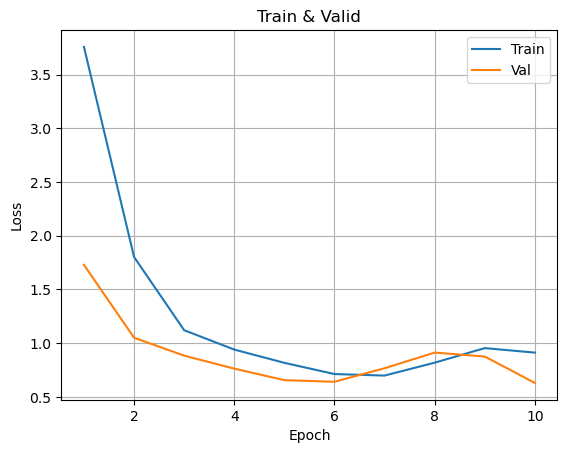

In [15]:
# 학습 후 loss 시각화
import matplotlib.pyplot as plt

plt.plot(range(1,11),loss[0], label='Train')
plt.plot(range(1,11),loss[1], label='Val')
plt.title('Train & Valid')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()